Markov Jump Process: Chemical Reaction
======================================

We consider the two Markov jump process models $m_1$ and $m_2$ for conversion of (chemical) species $X$ to species $Y$:

$$
  m_1: X + Y \xrightarrow{k_1} 2Y\\ m_2: X \xrightarrow{k_2} Y.
$$

Each model is equipped with a single rate parameter $k$.
To simulate these models, we define a simple Gillespie simulator:

In [1]:
import scipy as sp

def h(x, pre, c):
    return (x**pre).prod(1) * c

def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation
    
    Parameters
    ----------
    
    x: 1D array of size n_species
        The initial numbers.
    
    c: 1D array of size n_reactions
        The reaction rates.
    
    pre: array of size n_reactions x n_species
        What is to be consumed.
    
    post: array of size n_reactions x n_species
        What is to be produced
    
    max_t: int
        Timulate up to time max_t
        
    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``
    
    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = h(x, pre, c)
        h0 = h_vec.sum()
        delta_t = sp.random.exponential(1 / h0)
        # no reaction can occur any more
        if not sp.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = sp.random.choice(c.size, p=h_vec/h0)
        t = t + delta_t
        x = x + S[reaction]
        
        t_store.append(t)
        x_store.append(x)

    return sp.asarray(t_store), sp.asarray(x_store)

Next, we define the models in terms of ther initial molecule numbers $x_0$, an array ``pre`` which determines what is to be consumed (the left hand side of the reaction equations) and an array ``post`` which determines what is to be produced (the right hand side of the reaction equations).
Moreover, we define that the simulation time should not exceed ``MAX_T`` seconds.

Model 1 starts with initial concentrations $X=40$ and $Y=3$.
The reaction $X + Y \rightarrow 2Y$ is encoded in ``pre = [[1, 1]]`` and ``post = [[0, 2]]``.

In [2]:
MAX_T = 0.1

class Model1:
    __name__ = "Model 1"
    x0 = sp.array([40, 3])   # Initial molecule numbers
    pre = sp.array([[1, 1]], dtype=int)
    post = sp.array([[0, 2]])
    
    
    def __call__(self, par):
        t, X = gillespie(self.x0,
                         sp.array([float(par["rate"])]),
                         self.pre, self.post,
                         MAX_T)
        return {"t": t, "X" : X}

Model 2 inherits the initial concentration from model 1.
The reaction $X \rightarrow Y$ is incoded in ``pre = [[1, 0]]`` and ``post = [[0, 1]]``.

In [3]:
class Model2(Model1):
    __name__ = "Model 2"
    pre = sp.array([[1, 0]], dtype=int)
    post = sp.array([[0, 1]])

We draw one stochastic simulation from model 1 (the "Observation") and and one from model 2 (the "Competition") and visualize both

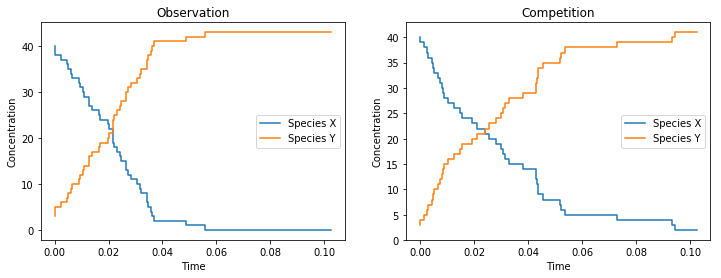

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

true_rate = 2.3
observations = [Model1()({"rate": true_rate}),
                Model2()({"rate": 30})]
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches((12, 4))
for ax, title, obs in zip(axes, ["Observation", "Competition"],
                          observations):
    ax.step(obs["t"], obs["X"]);
    ax.legend(["Species X", "Species Y"]);
    ax.set_xlabel("Time");
    ax.set_ylabel("Concentration");
    ax.set_title(title);

We observe that species $X$ is converted into species $Y$ in both cases.
The difference of the concentrations over time can be quite subtle.

We define a distance function as $L_1$ norm of two trajectories, evaluated at 20 time points:

$$
  \mathrm{distance}(X_1, X_2) =
     \sum_{n=1}^{N} 
           \left  |X_1(t_n) -X_2(t_n) 
           \right|, \quad t_n = \frac{n}{N}T, \quad  N=20 \,.
$$

Note that we only consider the concentration of species $X$ for distance calculation. And in code:

In [5]:
N_TEST_TIMES = 20

t_test_times = sp.linspace(0, MAX_T, N_TEST_TIMES)
def distance(x, y):
    xt_ind = sp.searchsorted(x["t"], t_test_times) - 1
    yt_ind = sp.searchsorted(y["t"], t_test_times) - 1
    error = (sp.absolute(x["X"][:,1][xt_ind]
                        - y["X"][:,1][yt_ind]).sum()
             / t_test_times.size)
    return error

For ABC, we choose for both models a uniform prior over the interval $[0, 100]$ for their single rate parameters:

In [6]:
from pyabc import Distribution, RV

prior = Distribution(rate=RV("uniform", 0, 100))

We initialize the ABCSMC class passing the two models, their priors and the distance function.

In [7]:
from pyabc import ABCSMC

abc = ABCSMC([Model1(),
              Model2()],
              [prior, prior],
               distance)

We initialize a new ABC run, taking as observed data the one generated by model 1.
The ABC run is to be stored in the sqlite database located at ``/tmp/mjp.db``.

In [8]:
abc_id = abc.new("sqlite:////tmp/mjp.db", observations[0])

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
INFO:Epsilon:initial epsilon is 5.8100000000000005
INFO:History:Start <ABCSMC(id=7, start_time=2017-09-12 14:16:42.487620, end_time=None)>


We start pyABC which automatically parallelizes across all available cores.

In [9]:
history = abc.run(minimum_epsilon=0, max_nr_populations=3)

INFO:ABC:t:0 eps:5.81
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
INFO:ABC:t:1 eps:2.8349999999999977
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered 

We first inspect the model probabilities.

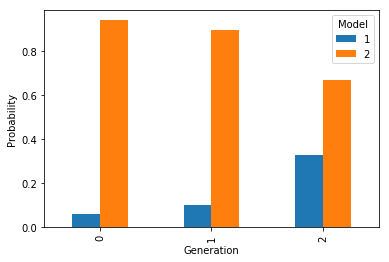

In [10]:
ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("Probability");
ax.set_xlabel("Generation");
ax.legend([1, 2], title="Model");

The mass at model 2 decreased, the mass at model 1 increased slowly.
The correct model 1 is detected towards the later generations.
We then inspect the distribution of the rate parameters:

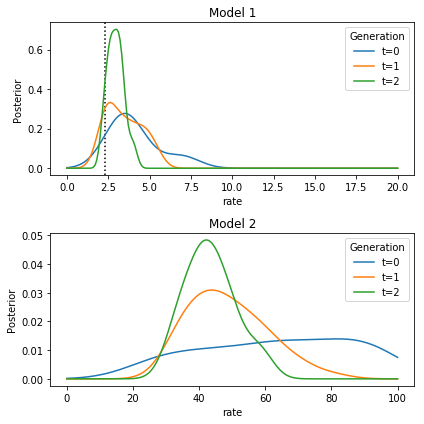

In [11]:
from pyabc.visualization import plot_kde_1d
fig, axes = plt.subplots(2)
fig.set_size_inches((6,6))
axes = axes.flatten()
axes[0].axvline(true_rate, color="black", linestyle="dotted")
for m, ax in enumerate(axes):
    for t in range(history.n_populations):
        df, w = history.get_distribution(m=m, t=t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, "rate", ax=ax, label=f"t={t}",
                        xmin=0, xmax=20 if m == 0 else 100,
                        numx=200)
    ax.set_title(f"Model {m+1}")
    ax.legend(title="Generation");
fig.tight_layout()

The true rate is closely approximated by the posterior over the rate of model 1.
It is a little harder to interpret the posterior over model 2.
Apparently a rate between 20 and 40 yields data most similar to the obserbed one.